In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# External Lib imports
import os
import re
import html
import pickle
import argparse
import pandas as pd
from pathlib import Path
from functools import partial

os.environ['QT_QPA_PLATFORM'] = 'offscreen'

# FastAI Imports
from fastai import text, core, lm_rnn

# Torch imports
import torch.nn as nn
import torch.optim as optim

# Mytorch imports
from mytorch import loops, lriters as mtlr, dataiters as mtdi
from mytorch.utils.goodies import *

# Local imports
from options import Phase3 as params

In [3]:
device = torch.device('cuda')
np.random.seed(42)
torch.manual_seed(42)

'''
    Paths and macros
'''
# Path fields
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

DATA_PATH = Path('raw/imdb/aclImdb/')
DATA_PATH.mkdir(exist_ok=True)
PATH = Path('resources/proc/imdb')
DATA_PROC_PATH = PATH / 'data'
DATA_LM_PATH = PATH / 'datalm'

LM_PATH = Path('resources/models')
LM_PATH.mkdir(exist_ok=True)
PRE_PATH = LM_PATH / 'wt103'
PRE_LM_PATH = PRE_PATH / 'fwd_wt103.h5'
CLASSES = ['neg', 'pos', 'unsup']


'''
    Model code
'''
class CustomEncoder(lm_rnn.MultiBatchRNN):
    @property
    def layers(self):
        # TODO: ADD ENCODERR!!!!!!!!!!
        return torch.nn.ModuleList([torch.nn.ModuleList([self.rnns[0], self.dropouths[0]]),
                                    torch.nn.ModuleList([self.rnns[1], self.dropouths[1]]),
                                    torch.nn.ModuleList([self.rnns[2], self.dropouths[2]])])


class TextClassifier(nn.Module):

    # @TODO: inject comments.
    def __init__(self, _device: torch.device, ntoken: int, dps: list, enc_wgts, _debug=False):
        super(TextClassifier, self).__init__()

        self.device = _device

        # Load the pre-trained model
        args = {'ntoken': ntoken, 'emb_sz': 400, 'n_hid': 1150,
                'n_layers': 3, 'pad_token': 0, 'qrnn': False, 'bptt': 70, 'max_seq': 1400,
                'dropouti': dps[0], 'wdrop': dps[1], 'dropoute': dps[2], 'dropouth': dps[3]}
        self.encoder = CustomEncoder(**args).to(self.device)
        self.encoder.load_state_dict(enc_wgts)
        '''
            Make new classifier.
            
            Explanation:
                400*3 because input is [ h_T, maxpool, meanpool ]
                50 is hidden layer dim
                2 is n_classes

                0.4, 0.1 are drops at various layers
        '''
        self.linear = text.PoolingLinearClassifier(layers=[400 * 3, 50, 2], drops=[dps[4], 0.1]).to(self.device)
        self.encoder.reset()

    @property
    def layers(self):
        layers = [x for x in self.encoder.layers]
        layers += [x for x in self.linear.layers]
        return torch.nn.ModuleList(layers)

    @property
    def layers_rev(self):
        layers = [x for x in self.encoder.layers]
        layers += [x for x in self.linear.layers]
        layers.reverse()
        return torch.nn.ModuleList(layers)

    def forward(self, x):
        # inputs are S*B

        # Encoding all the data
        op_p = self.encoder(x.transpose(1, 0))
        # pos_batch = op_p[1][-1][-1]
        score = self.linear(op_p)[0]

        return score

    def predict(self, x):
        with torch.no_grad():
            self.eval()
            predicted = self.forward(x)
            self.train()
            return predicted


'''
    Prepare data
'''
re1 = re.compile(r'  +')


def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))


def get_texts(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df.iloc[:, 1].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = text.Tokenizer().proc_all_mp(core.partition_by_cores(texts))
    return tok, list(labels)


def get_all(df, n_lbls):
    tok, labels = get_texts(df)
    return tok, labels


def get_texts_org(path):
    texts, labels = [], []
    for idx, label in enumerate(CLASSES):
        for fname in (path / label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)


def epoch_end_hook() -> None:
    lr_schedule.reset()


def eval(y_pred, y_true):
    """
        Expects a batch of input

        :param y_pred: tensor of shape (b, nc)
        :param y_true: tensor of shape (b, 1)
    """
    return torch.mean((torch.argmax(y_pred, dim=1) == y_true).float())

'\n    Paths and macros\n'

'\n    Model code\n'

'\n    Prepare data\n'

In [4]:
TRIM, DEBUG, MODEL_NUM = False, True, '3'
UNSUP_MODEL_DIR = PATH / 'models' / MODEL_NUM

trn_texts, trn_labels = get_texts_org(DATA_PATH / 'train')
val_texts, val_labels = get_texts_org(DATA_PATH / 'test')

# Lose label 2 from train
trn_texts = trn_texts[trn_labels<2]
trn_labels = trn_labels[trn_labels<2]

# Shuffle data
if TRIM:
    np.random.seed(42)
    trn_idx = np.random.permutation(len(trn_texts))[:1000]
    val_idx = np.random.permutation(len(val_texts))[:1000]
else:
    np.random.seed(42)
    trn_idx = np.random.permutation(len(trn_texts))
    val_idx = np.random.permutation(len(val_texts))

trn_texts, trn_labels = trn_texts[trn_idx], trn_labels[trn_idx]
val_texts, val_labels = val_texts[val_idx], val_labels[val_idx]
col_names = ['labels', 'text']

df_trn = pd.DataFrame({'text': trn_texts, 'labels': trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text': val_texts, 'labels': val_labels}, columns=col_names)

itos_path = UNSUP_MODEL_DIR / 'itos.pkl'
itos2 = pickle.load(itos_path.open('rb'))
stoi2 = {v: k for k, v in enumerate(itos2)}

trn_clas, trn_labels = get_all(df_trn, 1)
val_clas, val_labels = get_all(df_val, 1)

trn_clas = np.array([[stoi2.get(w, 0) for w in para] for para in trn_clas])
val_clas = np.array([[stoi2.get(w, 0) for w in para] for para in val_clas])
trn_labels = [x for y in trn_labels for x in y]
val_labels = [x for y in val_labels for x in y]

'''
    Make model
'''
dps = list(params.encoder_dropouts)
# enc_wgts = torch.load(LM_PATH, map_location=lambda storage, loc: storage)
enc_wgts = torch.load(UNSUP_MODEL_DIR / 'unsup_model_enc.torch', map_location=lambda storage, loc: storage)
clf = TextClassifier(device, len(itos2), dps, enc_wgts)

'''
    Setup things for training (data, loss, opt, lr schedule etc
'''
bs = params.bs
loss_fn = torch.nn.CrossEntropyLoss()
opt_fn = partial(optim.Adam, betas=params.adam_betas)
opt = make_opt(clf, opt_fn, lr=0.0)
opt.param_groups[-1]['lr'] = 0.01

# Make data
data_fn = partial(mtdi.SortishSampler, _batchsize=bs, _padidx=1)
data = {'train': {'x': trn_clas, 'y': trn_labels}, 'valid': {'x': val_clas, 'y': val_labels}}

# Make lr scheduler
lr_args = {'iterations': len(data_fn(data['train'])), 'cycles': 1}
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)

args = {'epochs': 1, 'data': data, 'device': device,
        'opt': opt, 'loss_fn': loss_fn, 'model': clf,
        'train_fn': clf, 'predict_fn': clf.predict,
        'epoch_end_hook': epoch_end_hook, 'weight_decay': params.weight_decay,
        'clip_grads_at': params.clip_grads_at, 'lr_schedule': lr_schedule,
        'data_fn': data_fn, 'eval_fn': eval}

'\n    Make model\n'

'\n    Setup things for training (data, loss, opt, lr schedule etc\n'

In [5]:
'''
    Training schedule:
    
    1. Unfreeze one layer. Train for 1 epoch
    2 - 5. Unfreeze one layer, train for 1 epoch
    3. Train for 15 epochs (after all layers are unfrozen). Use 15 cycles for cosine annealing.
'''
# opt.param_groups[-1]['lr'] = 0.01
traces = loops.generic_loop(**args)

opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
opt.param_groups[-3]['lr'] = 0.001
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
opt.param_groups[-3]['lr'] = 0.001
opt.param_groups[-4]['lr'] = 0.001
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
opt.param_groups[-3]['lr'] = 0.001
opt.param_groups[-4]['lr'] = 0.001
opt.param_groups[-5]['lr'] = 0.001
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

opt.param_groups[-1]['lr'] = 0.01
opt.param_groups[-2]['lr'] = 0.005
opt.param_groups[-3]['lr'] = 0.001
opt.param_groups[-4]['lr'] = 0.001
opt.param_groups[-5]['lr'] = 0.001
lr_args['cycles'] = 15
args['epochs'] = 15
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
args['lr_schedule'] = lr_schedule
traces_new = loops.generic_loop(**args)
traces = [a+b for a, b in zip(traces, traces_new)]

'\n    Training schedule:\n    \n    1. Unfreeze one layer. Train for 1 epoch\n    2 - 5. Unfreeze one layer, train for 1 epoch\n    3. Train for 15 epochs (after all layers are unfrozen). Use 15 cycles for cosine annealing.\n'

100%|██████████| 1042/1042 [01:32<00:00, 11.32it/s]


Epoch: 000 | Loss: 0.53399 | Tr_c: 0.73588 | Vl_c: 0.80312 | Time: 4.244 min


100%|██████████| 1042/1042 [01:32<00:00, 11.32it/s]


Epoch: 000 | Loss: 0.30545 | Tr_c: 0.87276 | Vl_c: 0.91959 | Time: 4.177 min


100%|██████████| 1042/1042 [01:32<00:00, 11.26it/s]


Epoch: 000 | Loss: 0.28512 | Tr_c: 0.88488 | Vl_c: 0.92650 | Time: 4.176 min


100%|██████████| 1042/1042 [01:31<00:00, 11.34it/s]


Epoch: 000 | Loss: 0.25688 | Tr_c: 0.90019 | Vl_c: 0.93790 | Time: 4.179 min


100%|██████████| 1042/1042 [01:31<00:00, 11.33it/s]


Epoch: 000 | Loss: 0.23067 | Tr_c: 0.91131 | Vl_c: 0.93734 | Time: 4.183 min


100%|██████████| 1042/1042 [01:31<00:00, 11.36it/s]


Epoch: 000 | Loss: 0.20860 | Tr_c: 0.92208 | Vl_c: 0.92842 | Time: 4.181 min


100%|██████████| 1042/1042 [01:31<00:00,  9.89it/s]


Epoch: 001 | Loss: 0.19842 | Tr_c: 0.92832 | Vl_c: 0.90263 | Time: 4.177 min


100%|██████████| 1042/1042 [01:32<00:00, 11.31it/s]


Epoch: 002 | Loss: 0.18890 | Tr_c: 0.93382 | Vl_c: 0.92330 | Time: 4.172 min


100%|██████████| 1042/1042 [01:32<00:00, 11.26it/s]


Epoch: 003 | Loss: 0.17646 | Tr_c: 0.93622 | Vl_c: 0.92878 | Time: 4.169 min


100%|██████████| 1042/1042 [01:31<00:00, 15.19it/s]


Epoch: 004 | Loss: 0.16513 | Tr_c: 0.94268 | Vl_c: 0.93046 | Time: 4.173 min


100%|██████████| 1042/1042 [01:31<00:00, 11.39it/s]


Epoch: 005 | Loss: 0.16229 | Tr_c: 0.94512 | Vl_c: 0.92806 | Time: 4.174 min


100%|██████████| 1042/1042 [01:31<00:00, 11.38it/s]


Epoch: 006 | Loss: 0.15143 | Tr_c: 0.94796 | Vl_c: 0.92806 | Time: 4.175 min


100%|██████████| 1042/1042 [01:31<00:00, 11.33it/s]


Epoch: 007 | Loss: 0.14311 | Tr_c: 0.95377 | Vl_c: 0.92578 | Time: 4.180 min


100%|██████████| 1042/1042 [01:31<00:00, 10.95it/s]


Epoch: 008 | Loss: 0.13484 | Tr_c: 0.95673 | Vl_c: 0.92598 | Time: 4.182 min


100%|██████████| 1042/1042 [01:32<00:00, 16.01it/s]


Epoch: 009 | Loss: 0.13283 | Tr_c: 0.95647 | Vl_c: 0.91763 | Time: 4.179 min


100%|██████████| 1042/1042 [01:31<00:00, 11.68it/s]


Epoch: 010 | Loss: 0.12843 | Tr_c: 0.95783 | Vl_c: 0.92770 | Time: 4.176 min


100%|██████████| 1042/1042 [01:31<00:00, 11.35it/s]


Epoch: 011 | Loss: 0.12946 | Tr_c: 0.95831 | Vl_c: 0.92055 | Time: 4.176 min


100%|██████████| 1042/1042 [01:32<00:00, 13.37it/s]


Epoch: 012 | Loss: 0.11810 | Tr_c: 0.96099 | Vl_c: 0.92990 | Time: 4.176 min


100%|██████████| 1042/1042 [01:32<00:00, 11.21it/s]


Epoch: 013 | Loss: 0.11128 | Tr_c: 0.96425 | Vl_c: 0.91641 | Time: 4.191 min


100%|██████████| 1042/1042 [01:32<00:00, 11.32it/s]

Epoch: 014 | Loss: 0.11665 | Tr_c: 0.96407 | Vl_c: 0.92316 | Time: 4.184 min


In [6]:
mt_save(UNSUP_MODEL_DIR,
            torch_stuff=[tosave('sup_model.torch', clf.state_dict())],
            pickle_stuff=[tosave('final_sup_traces.pkl', traces), tosave('unsup_options.pkl', params)])

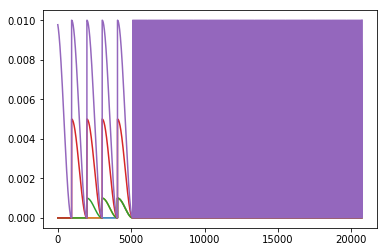

In [7]:
from matplotlib import pyplot as plt
def plot(trcs):
    layers = len(trcs[0])
    for l in range(layers):
        plt.plot(trcs[:,l], label=f"layer {l}")
    plt.show()
    
plot(np.asarray(traces[-1][100:]))

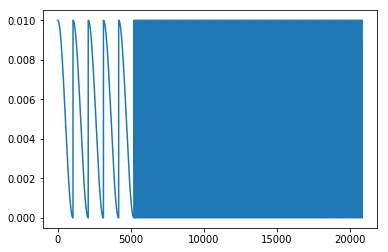

In [8]:
plot(np.asarray([[x[-1]] for x in traces[-1][:]]))

{'iterations': 1042, 'cycles': 15}


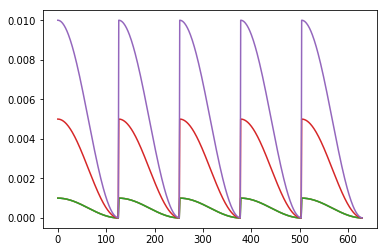

In [9]:
print(lr_args)
lr_args['cycles'] = 5
lr_args['iterations'] = 42*15
lr_schedule = mtlr.LearningRateScheduler(optimizer=opt, lr_args=lr_args, lr_iterator=mtlr.CosineAnnealingLR)
lrs = []
while True:
    try:
        lrs.append(lr_schedule.get())
    except CustomError:
        break
plot(np.asarray(lrs))

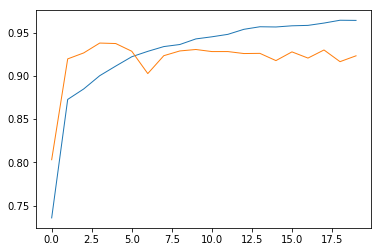

In [11]:
def plot_accs(tra, vla):
    
    fig = plt.figure()
#     ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
#     ax.spines['right'].set_color('none')
#     ax.spines['top'].set_color('none')
#     plt.xticks([])
#     plt.yticks([])
    plt.plot(tra, label=f"Train Acc", linewidth=1)
    plt.plot(vla, label=f"Valid Acc", linewidth=1)
#     plt.plot(axa, label=f"DAdNN Acc", linewidth=1)
    plt.show()
    
plot_accs(traces[0], traces[2])

In [10]:
UNSUP_MODEL_DIR

PosixPath('resources/proc/imdb/models/3')